In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
coin = 'KRW-SHIB'

In [4]:
df = pd.read_csv(f'../data/from_pyupbit/{coin}.csv')

In [5]:
df

,timestamp,open,high,low,close,volume,value
0,2023-01-18 16:05:00,0.01170,0.01600,0.01170,0.01580,1.594726e+12,2.499604e+10
1,2023-01-18 16:06:00,0.01580,0.01600,0.01550,0.01590,5.132315e+11,8.057362e+09
2,2023-01-18 16:07:00,0.01590,0.01590,0.01500,0.01540,4.836250e+11,7.472660e+09
3,2023-01-18 16:08:00,0.01550,0.01570,0.01530,0.01540,1.975731e+11,3.064142e+09
4,2023-01-18 16:09:00,0.01540,0.01560,0.01530,0.01560,2.032322e+11,3.155019e+09
...,...,...,...,...,...,...,...
751369,2024-10-12 20:38:00,0.02425,0.02426,0.02422,0.02422,6.611752e+09,1.602638e+08
751370,2024-10-12 20:39:00,0.02421,0.02422,0.02414,0.02422,1.863207e+10,4.506074e+08
751371,2024-10-12 20:40:00,0.02421,0.02421,0.02416,0.02417,2.853888e+09,6.904104e+07
751372,2024-10-12 20:41:00,0.02417,0.02421,0.02417,0.02421,3.873812e+09,9.374738e+07


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2023-01-18 16:05:00,0.01170,0.01600,0.01170,0.01580,1.594726e+12,2.499604e+10
2023-01-18 16:06:00,0.01580,0.01600,0.01550,0.01590,5.132315e+11,8.057362e+09
2023-01-18 16:07:00,0.01590,0.01590,0.01500,0.01540,4.836250e+11,7.472660e+09
2023-01-18 16:08:00,0.01550,0.01570,0.01530,0.01540,1.975731e+11,3.064142e+09
2023-01-18 16:09:00,0.01540,0.01560,0.01530,0.01560,2.032322e+11,3.155019e+09
...,...,...,...,...,...,...
2024-10-12 20:38:00,0.02425,0.02426,0.02422,0.02422,6.611752e+09,1.602638e+08
2024-10-12 20:39:00,0.02421,0.02422,0.02414,0.02422,1.863207e+10,4.506074e+08
2024-10-12 20:40:00,0.02421,0.02421,0.02416,0.02417,2.853888e+09,6.904104e+07


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, f'models/{coin}_scaler.pkl')

['models/KRW-SHIB_scaler.pkl']

In [9]:
timestep = 1

In [10]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
18785/18785 [==============================] - 262s 14ms/step - loss: 1.1548e-04 - val_loss: 1.6055e-06
Epoch 2/20
18785/18785 [==============================] - 257s 14ms/step - loss: 3.3108e-06 - val_loss: 6.3090e-07
Epoch 3/20
18785/18785 [==============================] - 255s 14ms/step - loss: 3.0140e-06 - val_loss: 6.8231e-07
Epoch 4/20
18785/18785 [==============================] - 241s 13ms/step - loss: 2.8322e-06 - val_loss: 3.2034e-06
Epoch 5/20
18785/18785 [==============================] - 98s 5ms/step - loss: 2.7292e-06 - val_loss: 2.8674e-07
Epoch 6/20
18785/18785 [==============================] - 100s 5ms/step - loss: 2.6537e-06 - val_loss: 2.4139e-06
Epoch 7/20
18785/18785 [==============================] - 97s 5ms/step - loss: 2.5575e-06 - val_loss: 1.8468e-06
Epoch 8/20
18785/18785 [==============================] - 96s 5ms/step - loss: 2.4766e-06 - val_loss: 2.8996e-07
Epoch 9/20
18785/18785 [==============================] - 94s 5ms/step - loss: 2.4284e-

In [19]:
model.save(f'models/lstm_{coin}.h5')

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4697/4697 [==============================] - 8s 2ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [22]:
test_predict

array([[0.02400039],
       [0.02400039],
       [0.0239904 ],
       ...,
       [0.02419021],
       [0.02419021],
       [0.02414026]], dtype=float32)

In [23]:
y_test

array([[0.02403, 0.02402, 0.02403, ..., 0.02422, 0.02417, 0.02421]])

In [24]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.6f}')
print(f'Test RMSE: {test_score:.6f}')

Train RMSE: 0.000078
Test RMSE: 0.000042


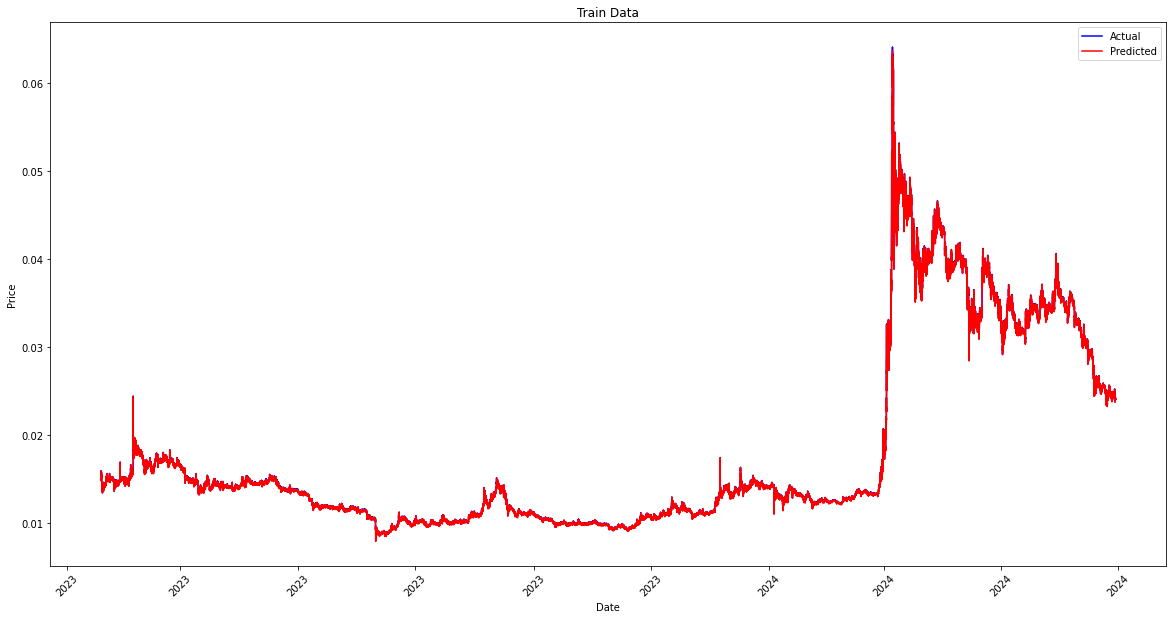

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

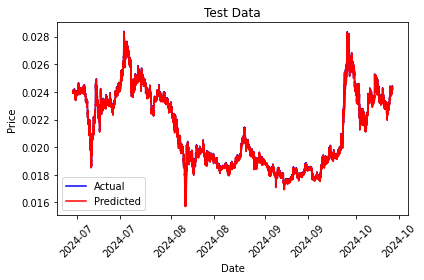

In [26]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [27]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.28932384]]


In [28]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 21ms/step
[[0.02413027]]


In [29]:
preds = []
for i in range(30):
    pred = model.predict(X_predict)
    preds.append(scaler.inverse_transform(pred)[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - 0s 15ms/step


In [30]:
preds

[0.024130272,
 0.024100572,
 0.0240709,
 0.024041254,
 0.024011636,
 0.023982042,
 0.023952475,
 0.023922931,
 0.023893416,
 0.023863921,
 0.02383445,
 0.023805004,
 0.023775578,
 0.023746176,
 0.023716794,
 0.023687437,
 0.0236581,
 0.023628782,
 0.023599485,
 0.023570208,
 0.023540951,
 0.023511712,
 0.02348249,
 0.023453288,
 0.023424102,
 0.023394935,
 0.02336578,
 0.023336645,
 0.023307525,
 0.02327842]